# Movies Dataset Processing & Analysis

![Movies Image](plugins/assets/movies_image.png)

### Objective:
The aim of this project is to fetch historical data about movies metadata from open APIs. The gathered data will be processed, cleaned, then will be stored in the data lake using AWS S3, loaded into Snowflake, and Visualize through dashboard. 

The [Kaggle Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data) that used contains metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

## Key Features of the Project:

### Data Collection:
Identify reliable open sources for movies dataset.
Use Python to fetch data using libraries such as requests, pandas, or openpyxl.


### Data Processing:
Clean and preprocess the data to ensure it's in a usable format.
Handle missing data, duplicates, and irrelevant columns.
Perform any necessary transformations (e.g., from json to dataset).

### Data Storage:
Store the data into the data lake (e.g., AWS S3) then load the data from data lake into data warehouse(e.g., Google BigQuery, AWS Redshift) for later use.


### Dashboard Development:
Use a Python visualization library (e.g., Plotly, Dash, Matplotlib) to build an interactive dashboard.
The dashboard will allow users to interact with data, filter by transport type, and visualize transport routes, schedules, or other metrics.


### Experimentation & Analysis:
Experiment with data fetching, transformation, and the integration of APIs.
Explore possible analyses such as peak-hour transport usage, performance (on-time arrivals), and comparison across routes.

### Load Libraries:

In [267]:
# Import all necessary packages
import pandas as pd
import numpy as np
import plugins.utils as utils
import snowflake.connector
from plugins.config import snow_creds, aws_creds
import json
from typing import Optional
import ast

## Data Collection:

In [268]:
# Download the dataset from Kaggle
dataset_name = "rounakbanik/the-movies-dataset" 
download_folder = "./plugins/assets/data/the-movies-dataset"
utils.download_kaggle_dataset(dataset_name, download_folder)

Folder './plugins/assets/data/the-movies-dataset' has been filled.


In [269]:
# Load all of the data into DataFrames
# The column ID -> identifier will be distinguished by using m_id which stands for movie_id (Most likely to be tmdbId in links df)
credits = pd.read_csv("./plugins/assets/data/the-movies-dataset/credits.csv")
keywords = pd.read_csv("./plugins/assets/data/the-movies-dataset/keywords.csv")
links = pd.read_csv("./plugins/assets/data/the-movies-dataset/links.csv")
movies_metadata = pd.read_csv("./plugins/assets/data/the-movies-dataset/movies_metadata.csv")
ratings = pd.read_csv("./plugins/assets/data/the-movies-dataset/ratings.csv")

## Data Processing:

In [270]:
def safe_parse_collection(x: pd.Series):
    if pd.isna(x):
        return np.nan
    
    if isinstance(x, dict):
        return x  # Already a dictionary, return as is
    
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError, TypeError):
        return np.nan
    
# AI Generated Code
def normalize_data(
    df: pd.DataFrame, 
    subset_column: str, 
    id_column: str,
    prefix: str
) -> pd.DataFrame:
    """Optimized normalization of nested data using vectorized operations."""
    # Create working copy with only necessary columns
    working_df = df[[id_column, subset_column]].copy()
    
    # Vectorized parsing of nested data
    working_df[subset_column] = working_df[subset_column].apply(safe_parse_collection)
    
    # Filter valid entries and explode lists
    valid_mask = working_df[subset_column].apply(
        lambda x: isinstance(x, list) and len(x) > 0 and all(isinstance(i, dict) for i in x)
    )
    exploded_df = working_df[valid_mask].explode(subset_column)
    
    if exploded_df.empty:
        return pd.DataFrame()
    
    # Normalize nested dicts in vectorized manner
    normalized = pd.json_normalize(exploded_df[subset_column])
    
    # Add reference ID with type conversion for memory efficiency
    id_col_name = f"{prefix}_{id_column}"
    normalized[id_col_name] = exploded_df[id_column].astype(
        exploded_df[id_column].dtype
    ).values
    
    return normalized.reset_index(drop=True)

def extract_dict_values(
    df: pd.DataFrame, 
    column_name: str, 
    new_column_prefix: Optional[str] = None
) -> pd.DataFrame:
    """Optimized dictionary expansion using vectorized operations."""
    # Parse and normalize in bulk
    parsed = df[column_name].apply(safe_parse_collection)
    normalized = pd.json_normalize(parsed)
    
    # Apply prefix if specified
    if new_column_prefix:
        normalized = normalized.add_prefix(f"{new_column_prefix}_")
    
    # Join results using pandas' efficient merge instead of row-wise operations
    return pd.concat([df, normalized], axis=1)

#### Credits Dataframe Processing:

In [271]:
# Take a peek of current credits data
credits.sample(5)

,cast,crew,id
24460,"[{'cast_id': 1, 'character': 'Prof. Fluke Kels...","[{'credit_id': '52fe447e9251416c91012abd', 'de...",31446
7750,"[{'cast_id': 4, 'character': 'Constable Brenda...","[{'credit_id': '52fe45dcc3a36847f80de925', 'de...",41774
30621,[],"[{'credit_id': '52fe4cb8c3a368484e1c4055', 'de...",201913
23278,"[{'cast_id': 2, 'character': 'Himself', 'credi...","[{'credit_id': '52fe4e2f9251416c91129485', 'de...",252143
41966,"[{'cast_id': 3, 'character': 'Allan Karlsson',...","[{'credit_id': '577a2369c3a36878e800297c', 'de...",404791


In [272]:
c_cast = normalize_data(credits, 'cast', 'id', 'm')
c_crew = normalize_data(credits, 'crew', 'id', 'm')

Process c_cast dataframe

In [273]:
c_cast.sample(5)

,cast_id,character,credit_id,gender,id,name,order,profile_path,m_id
510269,2,Clov,52fe4786c3a368484e0cbda5,2,11207,David Thewlis,1,/1YhN379UKCPt94nbLzncsDHTC9T.jpg,68139
213094,27,Sudimack,52fe462d9251416c7506fb4f,2,81829,Michael Hayden,5,None,14979
424740,9,Young Gisani,52fe46eac3a36847f81196e5,2,135387,Thabo Malema,2,None,46197
541304,9,Zhoo,57f0becbc3a3683fac009347,0,993943,Mark Chao,5,/i8rgRpr4cSt6Yh7BlrWlNKKpOd6.jpg,413658
312000,23,Herself,56dd6d01c3a368765c003206,1,20234,Fanny Ardant,10,/ealXbfCd6oCubRDA3PMgKlq6xq.jpg,179144


In [274]:
c_cast.gender.value_counts()

gender
2    226713
0    223964
1    111797
Name: count, dtype: int64

In [275]:
# c_cast preview
c_cast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562474 entries, 0 to 562473
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   cast_id       562474 non-null  int64 
 1   character     562474 non-null  object
 2   credit_id     562474 non-null  object
 3   gender        562474 non-null  int64 
 4   id            562474 non-null  int64 
 5   name          562474 non-null  object
 6   order         562474 non-null  int64 
 7   profile_path  388618 non-null  object
 8   m_id          562474 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 38.6+ MB


Data cleaning process for c_cast

In [276]:
# Check for duplicated columns
c_cast[c_cast.duplicated(subset=['cast_id', 'credit_id', 'm_id', 'name'], keep=False)].sort_values(by=['cast_id', 'credit_id'])

,cast_id,character,credit_id,gender,id,name,order,profile_path,m_id
71117,1,Ash Ketchum,52fe43de9251416c750213f1,1,67830,Veronica Taylor,0,/28EFUb3bPWJaWYzZIxurGCrDpHk.jpg,10991
557033,1,Ash Ketchum,52fe43de9251416c750213f1,1,67830,Veronica Taylor,0,/28EFUb3bPWJaWYzZIxurGCrDpHk.jpg,10991
16653,1,Catherine Barkley,52fe444ac3a368484e01aad5,0,47439,Helen Hayes,0,/6QJDTvIT0v5E9pR1rgPtq59Ej8.jpg,22649
235036,1,Catherine Barkley,52fe444ac3a368484e01aad5,0,47439,Helen Hayes,0,/6QJDTvIT0v5E9pR1rgPtq59Ej8.jpg,22649
132474,1,Lafcadia - Warrior,52fe4465c3a368484e020913,2,76793,Irrfan Khan,0,/9O71WSILj1af9smwuN44nGd198Q.jpg,23305
...,...,...,...,...,...,...,...,...,...
512939,1011,Betty's Hawaiian Maid,52fe49fb9251416c750d9d99,0,1109654,Lola Gonzales,10,None,97995
219993,1012,Max's Chef - in Mirror Gag,52fe49fc9251416c750d9d9d,0,1109655,Harry Mann,11,None,97995
512940,1012,Max's Chef - in Mirror Gag,52fe49fc9251416c750d9d9d,0,1109655,Harry Mann,11,None,97995
219994,1013,The Chimpanzee,52fe49fc9251416c750d9da1,0,1109656,Joe Martin,12,None,97995


In [277]:
c_cast.drop_duplicates(subset=['cast_id', 'credit_id'], keep='first', inplace=True)

Validate cleaning

In [278]:
# Validate cleaning process
c_cast[c_cast.duplicated(subset=['cast_id', 'credit_id', 'm_id', 'name'], keep=False)].sort_values(by=['cast_id', 'credit_id']).count()

cast_id         0
character       0
credit_id       0
gender          0
id              0
name            0
order           0
profile_path    0
m_id            0
dtype: int64

In [279]:
c_cast.profile_path.str.split('.').str[-1].value_counts()

profile_path
jpg    388366
Name: count, dtype: int64

In [280]:
c_cast.isnull().sum()

cast_id              0
character            0
credit_id            0
gender               0
id                   0
name                 0
order                0
profile_path    173678
m_id                 0
dtype: int64

Process c_crew dataset

In [281]:
c_crew.sample(5)

,credit_id,department,gender,id,job,name,profile_path,m_id
256146,52fe45ab9251416c7505e61d,Editing,2,54592,Editor,Danny Saphire,None,13830
352711,52fe4df09251416c751461b7,Directing,2,103156,Director,Mario Bianchi,None,222517
220928,52fe4677c3a36847f8100abb,Directing,2,2034,Director,Danny Boyle,/b5qQpFHmgNyvV1t81ou17Jt2fRj.jpg,44115
108794,52fe45eac3a36847f80e1df3,Writing,2,2355,Screenplay,Andrew Birkin,None,42040
164064,5546885bc3a36856e5004620,Visual Effects,0,1462623,Visual Development,Sam Michlap,None,15213


In [282]:
# c_crew preview
c_crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464314 entries, 0 to 464313
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   credit_id     464314 non-null  object
 1   department    464314 non-null  object
 2   gender        464314 non-null  int64 
 3   id            464314 non-null  int64 
 4   job           464314 non-null  object
 5   name          464314 non-null  object
 6   profile_path  95098 non-null   object
 7   m_id          464314 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 28.3+ MB


Data cleaning process for c_crew

In [283]:
# Check for duplicated columns
c_crew[c_crew.duplicated(subset=['id', 'credit_id', 'm_id', 'name'], keep=False)].sort_values(by=['id', 'credit_id'])

,credit_id,department,gender,id,job,name,profile_path,m_id
259782,55c0d60e9251410f19001cec,Production,1,32,Producer,Robin Wright,/tXfQTgcIEPP7gtVdJ44ZxZPhacn.jpg,152795
278138,55c0d60e9251410f19001cec,Production,1,32,Producer,Robin Wright,/tXfQTgcIEPP7gtVdJ44ZxZPhacn.jpg,152795
90620,52fe43e2c3a36847f80760b5,Writing,2,202,Screenplay,Charlie Kaufman,/v5Zc2aplTL0y38Oe91zGnVBUtYi.jpg,4912
379605,52fe43e2c3a36847f80760b5,Writing,2,202,Screenplay,Charlie Kaufman,/v5Zc2aplTL0y38Oe91zGnVBUtYi.jpg,4912
317389,52fe4655c3a36847f80f96bf,Directing,2,525,Director,Christopher Nolan,/7OGmfDF4VHLLgbjxuEwTj3ga0uQ.jpg,43629
...,...,...,...,...,...,...,...,...
317743,596bdc83c3a3684c0200548b,Editing,0,1852798,Dialogue Editor,Matt Gorzkowski,None,199591
317345,596bdcd9c3a3684bcb004d02,Sound,0,1852799,Sound Effects Editor,Michael Hanlan,None,199591
317744,596bdcd9c3a3684bcb004d02,Sound,0,1852799,Sound Effects Editor,Michael Hanlan,None,199591
317346,596bdfcac3a3684c02005741,Costume & Make-Up,0,1852802,Wardrobe Supervisor,Jasmine Murray-Bergquist,None,199591


In [284]:
c_crew.drop_duplicates(subset=['id', 'credit_id', 'm_id', 'name'], keep='first', inplace=True)

Validate cleaning

In [285]:
c_crew[c_crew.duplicated(subset=['id', 'credit_id', 'm_id', 'name'], keep=False)].sort_values(by=['id', 'credit_id']).count()

credit_id       0
department      0
gender          0
id              0
job             0
name            0
profile_path    0
m_id            0
dtype: int64

In [286]:
c_crew.profile_path.str.split('.').str[-1].value_counts()

profile_path
jpg    95001
Name: count, dtype: int64

In [287]:
c_crew.isnull().sum()

credit_id            0
department           0
gender               0
id                   0
job                  0
name                 0
profile_path    368835
m_id                 0
dtype: int64

#### Keywords Dataframe Processing:

In [288]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [289]:
keywords = normalize_data(keywords, 'keywords', 'id', 'm')

In [290]:
keywords.head(5)

,id,name,m_id
0,931,jealousy,862
1,4290,toy,862
2,5202,boy,862
3,6054,friendship,862
4,9713,friends,862


Data Cleaning process

In [291]:
pd.DataFrame(keywords.name.value_counts())

,count
name,
woman director,3115
independent film,1930
murder,1308
based on novel,835
musical,734
...,...
helping animals,1
animal agriculture,1
brother sister,1


In [292]:
# Check for duplicated columns
keywords[keywords.duplicated(keep=False)].sort_values(by=['id', 'name', 'm_id'])

,id,name,m_id
137369,65,holiday,19252
139324,65,holiday,19252
135581,65,holiday,26381
137536,65,holiday,26381
135628,65,holiday,26537
...,...,...,...
138012,237651,dreamland,325712
136432,238208,dead end road,23382
138387,238208,dead end road,23382
136265,238539,corrupt sheriff,325173


In [293]:
keywords[keywords.duplicated(keep=False)].sort_values(by=['id', 'name', 'm_id']).count()

id      4156
name    4156
m_id    4156
dtype: int64

In [294]:
keywords.drop_duplicates(keep='first', inplace=True)

Validate

In [295]:
keywords[keywords.duplicated(keep=False)].sort_values(by=['id', 'name', 'm_id']).count()

id      0
name    0
m_id    0
dtype: int64

In [296]:
keywords.isnull().sum()

id      0
name    0
m_id    0
dtype: int64

#### Links Dataframe Processing:

In [297]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [298]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  45843 non-null  int64  
 1   imdbId   45843 non-null  int64  
 2   tmdbId   45624 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.0 MB


In [299]:
links['tmdbId'] = links.tmdbId.fillna(0).astype(int)

Validate

In [300]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   movieId  45843 non-null  int64
 1   imdbId   45843 non-null  int64
 2   tmdbId   45843 non-null  int64
dtypes: int64(3)
memory usage: 1.0 MB


In [301]:
links.isnull().sum()

movieId    0
imdbId     0
tmdbId     0
dtype: int64

#### Movies Metaddata Dataframe Processing:

In [302]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173


In [329]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   adult              45463 non-null  bool   
 1   budget             45463 non-null  int64  
 2   homepage           7779 non-null   object 
 3   id                 45463 non-null  int64  
 4   imdb_id            45446 non-null  object 
 5   original_language  45452 non-null  object 
 6   original_title     45463 non-null  object 
 7   overview           44509 non-null  object 
 8   popularity         45463 non-null  float64
 9   poster_path        45080 non-null  object 
 10  release_date       45379 non-null  object 
 11  revenue            45463 non-null  int64  
 12  runtime            45206 non-null  float64
 13  status             45382 non-null  object 
 14  tagline            20413 non-null  object 
 15  title              45463 non-null  object 
 16  video              454

Cleaning & convert data type

In [330]:
movies_metadata['release_date'] = pd.to_datetime(movies_metadata.release_date)

Validate

In [338]:
movies_metadata.release_date.info()

<class 'pandas.core.series.Series'>
RangeIndex: 45463 entries, 0 to 45462
Series name: release_date
Non-Null Count  Dtype         
--------------  -----         
45379 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 355.3 KB


In [303]:
# Inspect the first row of the movies_metadata DataFrame to decide the processing method
movies_metadata.iloc[0]

adult                                                                False
belongs_to_collection    {'id': 10194, 'name': 'Toy Story Collection', ...
budget                                                            30000000
genres                   [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
homepage                              http://toystory.disney.com/toy-story
id                                                                     862
imdb_id                                                          tt0114709
original_language                                                       en
original_title                                                   Toy Story
overview                 Led by Woody, Andy's toys live happily in his ...
popularity                                                       21.946943
poster_path                               /rhIRbceoE9lR4veEXuwCC2wARtG.jpg
production_companies        [{'name': 'Pixar Animation Studios', 'id': 3}]
production_countries     

Extracting belongs_to_collection DataFrame

In [304]:
def extract_dict_values(row: pd.DataFrame, column_name: str, new_column_prefix: str = None):
    new_row = safe_parse_collection(row[column_name])
    if isinstance(new_row, dict):
        for key, value in new_row.items():
            if new_column_prefix:
                row[f'{new_column_prefix}_{key}'] = value
            else:
                row[key] = value
    return row

belongs_to_collection = movies_metadata[['belongs_to_collection', 'id']].copy()
belongs_to_collection.rename(columns={'id': 'm_id'}, inplace=True)
belongs_to_collection = belongs_to_collection.apply(lambda row: extract_dict_values(row, 'belongs_to_collection'), axis=1)
movies_metadata.drop('belongs_to_collection', axis=1, inplace=True)
belongs_to_collection = belongs_to_collection.drop('belongs_to_collection', axis=1)

Process & cleaning belongs_to_collection DataFrame

In [305]:
# Take a look of the top 5 rows of the belongs_to_collection DataFrame
belongs_to_collection.head()

,backdrop_path,id,m_id,name,poster_path
0,/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg,10194.0,862,Toy Story Collection,/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg
1,NaN,NaN,8844,NaN,NaN
2,/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg,119050.0,15602,Grumpy Old Men Collection,/nLvUdqgPgm3F85NMCii9gVFUcet.jpg
3,NaN,NaN,31357,NaN,NaN
4,/7qwE57OVZmMJChBpLEbJEmzUydk.jpg,96871.0,11862,Father of the Bride Collection,/nts4iOmNnq7GNicycMJ9pSAn204.jpg


In [306]:
# Inspect the data type
belongs_to_collection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   backdrop_path  3263 non-null   object 
 1   id             4491 non-null   float64
 2   m_id           45463 non-null  int64  
 3   name           4491 non-null   object 
 4   poster_path    3948 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.7+ MB


In [307]:
# Remove rows with missing values
mask = belongs_to_collection[['id', 'name']].isna().all(axis=1)
belongs_to_collection = belongs_to_collection[~mask]
belongs_to_collection.head()

,backdrop_path,id,m_id,name,poster_path
0,/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg,10194.0,862,Toy Story Collection,/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg
2,/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg,119050.0,15602,Grumpy Old Men Collection,/nLvUdqgPgm3F85NMCii9gVFUcet.jpg
4,/7qwE57OVZmMJChBpLEbJEmzUydk.jpg,96871.0,11862,Father of the Bride Collection,/nts4iOmNnq7GNicycMJ9pSAn204.jpg
9,/6VcVl48kNKvdXOZfJPdarlUGOsk.jpg,645.0,710,James Bond Collection,/HORpg5CSkmeQlAolx3bKMrKgfi.jpg
12,/9VM5LiJV0bGb1st1KyHA3cVnO2G.jpg,117693.0,21032,Balto Collection,/w0ZgH6Lgxt2bQYnf1ss74UvYftm.jpg


Validate

In [308]:
# Inspect the data type
belongs_to_collection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4491 entries, 0 to 45379
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   backdrop_path  3263 non-null   object 
 1   id             4491 non-null   float64
 2   m_id           4491 non-null   int64  
 3   name           4491 non-null   object 
 4   poster_path    3948 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 210.5+ KB


Extracting and separating genres column

In [309]:
genres = normalize_data(movies_metadata, 'genres', 'id', 'm')
movies_metadata.drop(columns=['genres'], inplace=True)
genres.sample(5)

,id,name,m_id
23604,80,Crime,26332
74098,18,Drama,42748
58579,18,Drama,39433
8834,10749,Romance,10641
85867,18,Drama,358926


Validate

In [310]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91094 entries, 0 to 91093
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      91094 non-null  int64 
 1   name    91094 non-null  object
 2   m_id    91094 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ MB


Extracting production_companies column

In [311]:
production_companies = normalize_data(movies_metadata, 'production_companies', 'id', 'm')
movies_metadata.drop(columns=['production_companies'], inplace=True)
production_companies.sort_values(by='id').head()

,name,id,m_id
4053,Lucasfilm,1,847
570,Lucasfilm,1,11
2474,Lucasfilm,1,89
4517,Lucasfilm,1,10658
3889,Lucasfilm,1,87


Cleaning process

In [312]:
production_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70557 entries, 0 to 70556
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    70557 non-null  object
 1   id      70557 non-null  int64 
 2   m_id    70557 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.6+ MB


Extracting production_countries DataFrame

In [313]:
production_countries = normalize_data(movies_metadata, 'production_countries', 'id', 'm')
movies_metadata.drop(columns=['production_countries'], inplace=True)
production_countries.sample(5)

,iso_3166_1,name,m_id
4353,US,United States of America,36047
47314,US,United States of America,401484
3487,US,United States of America,1832
547,US,United States of America,16297
21868,CN,China,55292


Validate

In [314]:
production_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49430 entries, 0 to 49429
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   iso_3166_1  49430 non-null  object
 1   name        49430 non-null  object
 2   m_id        49430 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Extracting spoken_languages DataFrame

In [315]:
spoken_languages = normalize_data(movies_metadata, 'spoken_languages', 'id', 'm')
movies_metadata.drop(columns=['spoken_languages'], inplace=True)
spoken_languages.sample(5)

,iso_639_1,name,m_id
38046,en,English,16390
19449,ru,Pусский,83491
52026,en,English,89763
19200,en,English,24056
2076,en,English,55306


Validate

In [316]:
spoken_languages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53303 entries, 0 to 53302
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   iso_639_1  53303 non-null  object
 1   name       53303 non-null  object
 2   m_id       53303 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


#### Validate whether the data is valid and related

In [317]:
# Taking sample
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [318]:
credits[credits['id'] == 110]

,cast,crew,id
302,"[{'cast_id': 9, 'character': 'Valentine Dussau...","[{'credit_id': '52fe4219c3a36847f8003dbd', 'de...",110


In [319]:
c_cast[c_cast['id'] == 110].head()

,cast_id,character,credit_id,gender,id,name,order,profile_path,m_id
2674,4,Lt. Peter 'WEAPS' Ince,52fe44ccc3a36847f80aa7e9,2,110,Viggo Mortensen,4,/gYtVNMwX96fE9F0WVkdC0SGffkn.jpg,8963
3110,14,Lucifer,535e9b58c3a36830a9005700,2,110,Viggo Mortensen,5,/gYtVNMwX96fE9F0WVkdC0SGffkn.jpg,11980
7041,11,Lalin,52fe443bc3a36847f8089ef7,2,110,Viggo Mortensen,7,/gYtVNMwX96fE9F0WVkdC0SGffkn.jpg,6075
12512,11,Roy Nord,52fe44159251416c75028531,2,110,Viggo Mortensen,2,/gYtVNMwX96fE9F0WVkdC0SGffkn.jpg,11228
23655,7,Guy Foucard,52fe44b7c3a36847f80a5f6f,2,110,Viggo Mortensen,4,/gYtVNMwX96fE9F0WVkdC0SGffkn.jpg,8744


In [320]:
c_crew[c_crew['id'] == 110].head()

,credit_id,department,gender,id,job,name,profile_path,m_id
344703,5545f2619251414c92003c16,Production,2,110,Co-Producer,Viggo Mortensen,/gYtVNMwX96fE9F0WVkdC0SGffkn.jpg,283708


In [321]:
keywords[keywords['m_id'] == 110].head()

,id,name,m_id
2028,934,judge,110
2029,1533,isolation,110
2030,2863,mannequin,110
2031,4918,shadowing,110
2032,5259,english channel,110


In [322]:
links[links['tmdbId'] == 110].head()

,movieId,imdbId,tmdbId
303,306,111495,110


[Link validation](https://www.imdb.com/title/tt0111495/)

In [323]:
movies_metadata[movies_metadata['id'] == 110]

,adult,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,revenue,runtime,status,tagline,title,video,vote_average,vote_count
302,False,0,NaN,110,tt0111495,fr,Trois couleurs : Rouge,Red This is the third film from the trilogy by...,7.832755,/77CFEssoKesi4zvtADEpIrSKhA3.jpg,1994-05-27,0,99.0,Released,NaN,Three Colors: Red,False,7.8,246


In [324]:
belongs_to_collection[belongs_to_collection['m_id'] == 110]

,backdrop_path,id,m_id,name,poster_path
302,/AeHExfHIl70SZCea907KfEoSkfJ.jpg,131.0,110,Three Colors Collection,/rVdd23QuT5rHX7lZvuAkRRUkeCZ.jpg


In [325]:
genres[genres['m_id'] == 110]

,id,name,m_id
726,18,Drama,110
727,9648,Mystery,110
728,10749,Romance,110


In [326]:
production_companies[production_companies['m_id'] == 110]

,name,id,m_id
674,Zespół Filmowy TOR,38,110
675,Le Studio Canal+,183,110
676,France 3 Cinéma,591,110
677,Télévision Suisse-Romande,1245,110


In [327]:
production_countries[production_countries['m_id'] == 110]

,iso_3166_1,name,m_id
375,FR,France,110
376,PL,Poland,110
377,CH,Switzerland,110


In [328]:
spoken_languages[spoken_languages['m_id'] == 110]

,iso_639_1,name,m_id
414,fr,Français,110


## Notes
- Data on movies_metadata with id 82663, 122662, 249260 have manual correction in the csv
- With this all of the data can be concluded to be integrated and validated based on it's ID

## Create simple visualization

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns

What is the total budget for filming industry over the year?

In [365]:
yearly_budget = movies_metadata.groupby(movies_metadata.release_date.dt.year).budget.sum().reset_index()

# Remove insignificant data
yearly_budget = yearly_budget[yearly_budget.budget != 0].sort_values(by='budget', ascending=False).head(50)

In [366]:
yearly_budget.head()

,release_date,budget
131,2016.0,10411197116
125,2010.0,10024513022
128,2013.0,10006134305
126,2011.0,9717615625
124,2009.0,9517429281


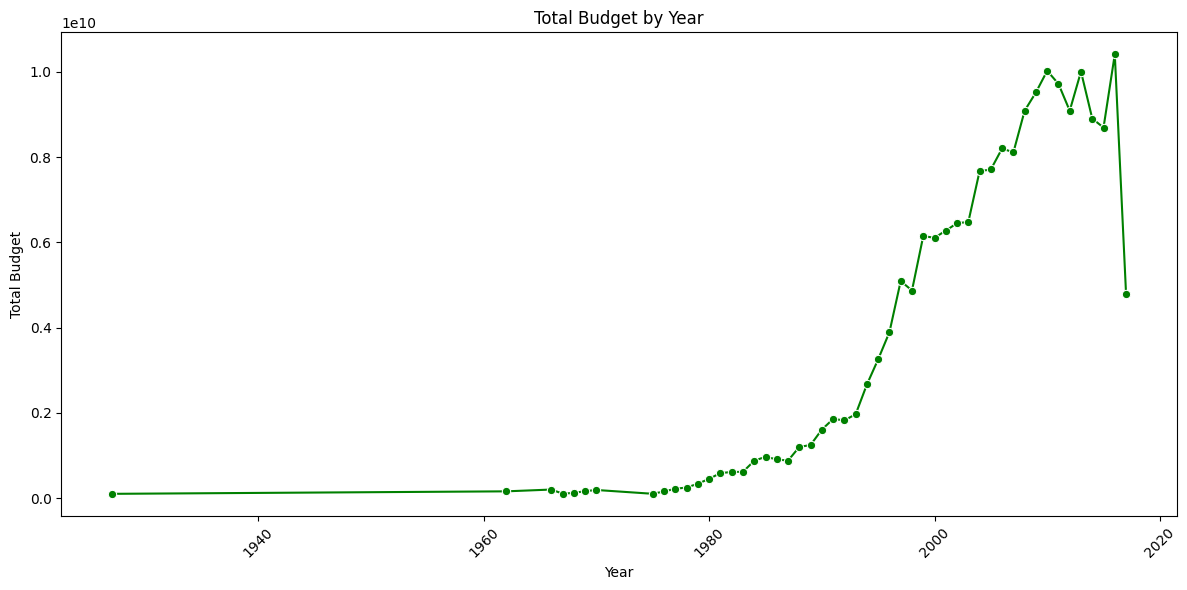

In [432]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_budget, x='release_date', y='budget', marker='o', color='green')
plt.title('Total Budget by Year')
plt.xlabel('Year')
plt.ylabel('Total Budget')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Top 10 movies with the most revenue

In [396]:
top_10_revenue = movies_metadata.sort_values(by='revenue', ascending=False).head(10)[['title', 'revenue']]

In [429]:
def top_10_revenue_plot(top_10_revenue):
    plt.figure(figsize=(12, 10))

    # Create the bar plot
    ax = sns.barplot(data=top_10_revenue, y='title', x='revenue', color='skyblue')

    plt.title('Top 10 Movies by Revenue', fontsize=14)
    plt.xlabel('Revenue', fontsize=12)
    plt.ylabel('Movie', fontsize=12)

    # Add value labels to the end of each bar
    for i in ax.containers[0]:
        width = i.get_width()
        # Format large numbers
        if width >= 1_000_000_000:
            label = f'${width/1_000_000_000:.2f}B'
        elif width >= 1_000_000:
            label = f'${width/1_000_000:.2f}M'
        else:
            label = f'${width:,.0f}'
        
        ax.text(width + i.get_width().min() * 0.01, i.get_y() + i.get_height()/2, label, 
                va='center', ha='left', fontsize=10)

    plt.tight_layout()
    plt.show()

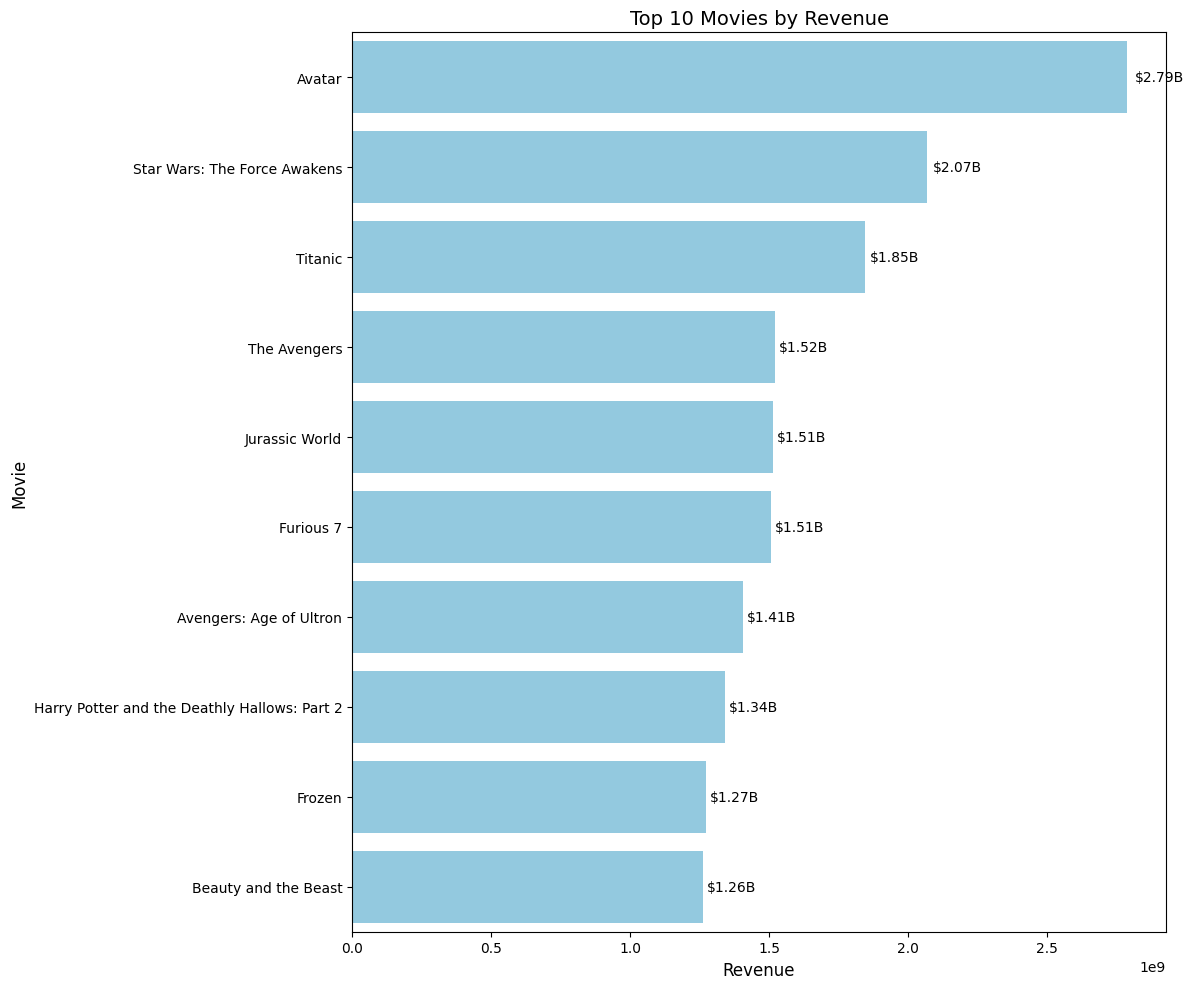

In [430]:
top_10_revenue_plot(top_10_revenue)